# 词嵌入（word2vec）
:label:`sec_word2vec`

自然语言是用来表达人脑思维的复杂系统。
在这个系统中，词是意义的基本单元。顾名思义，
*词向量*是用于表示单词意义的向量，
并且还可以被认为是单词的特征向量或表示。
将单词映射到实向量的技术称为*词嵌入*。
近年来，词嵌入逐渐成为自然语言处理的基础知识。

## 为何独热向量是一个糟糕的选择

在 :numref:`sec_rnn_scratch`中，我们使用独热向量来表示词（字符就是单词）。假设词典中不同词的数量（词典大小）为$N$，每个词对应一个从$0$到$N−1$的不同整数（索引）。为了得到索引为$i$的任意词的独热向量表示，我们创建了一个全为0的长度为$N$的向量，并将位置$i$的元素设置为1。这样，每个词都被表示为一个长度为$N$的向量，可以直接由神经网络使用。

虽然独热向量很容易构建，但它们通常不是一个好的选择。一个主要原因是独热向量不能准确表达不同词之间的相似度，比如我们经常使用的“余弦相似度”。对于向量$\mathbf{x}, \mathbf{y} \in \mathbb{R}^d$，它们的余弦相似度是它们之间角度的余弦：

$$\frac{\mathbf{x}^\top \mathbf{y}}{\|\mathbf{x}\| \|\mathbf{y}\|} \in [-1, 1].$$

由于任意两个不同词的独热向量之间的余弦相似度为0，所以独热向量不能编码词之间的相似性。

## 自监督的word2vec

[word2vec](https://code.google.com/archive/p/word2vec/)工具是为了解决上述问题而提出的。它将每个词映射到一个固定长度的向量，这些向量能更好地表达不同词之间的相似性和类比关系。word2vec工具包含两个模型，即*跳元模型*（skip-gram） :cite:`Mikolov.Sutskever.Chen.ea.2013`和*连续词袋*（CBOW） :cite:`Mikolov.Chen.Corrado.ea.2013`。对于在语义上有意义的表示，它们的训练依赖于条件概率，条件概率可以被看作使用语料库中一些词来预测另一些单词。由于是不带标签的数据，因此跳元模型和连续词袋都是自监督模型。

下面，我们将介绍这两种模式及其训练方法。

## 跳元模型（Skip-Gram）
:label:`subsec_skip-gram`

跳元模型假设一个词可以用来在文本序列中生成其周围的单词。以文本序列“the”“man”“loves”“his”“son”为例。假设*中心词*选择“loves”，并将上下文窗口设置为2，如图 :numref:`fig_skip_gram`所示，给定中心词“loves”，跳元模型考虑生成*上下文词*“the”“man”“him”“son”的条件概率：

$$P(\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}\mid\textrm{"loves"}).$$

假设上下文词是在给定中心词的情况下独立生成的（即条件独立性）。在这种情况下，上述条件概率可以重写为：

$$P(\textrm{"the"}\mid\textrm{"loves"})\cdot P(\textrm{"man"}\mid\textrm{"loves"})\cdot P(\textrm{"his"}\mid\textrm{"loves"})\cdot P(\textrm{"son"}\mid\textrm{"loves"}).$$

![跳元模型考虑了在给定中心词的情况下生成周围上下文词的条件概率](img/skip-gram.svg)
:label:`fig_skip_gram`

在跳元模型中，每个词都有两个$d$维向量表示，用于计算条件概率。更具体地说，对于词典中索引为$i$的任何词，分别用$\mathbf{v}_i\in\mathbb{R}^d$和$\mathbf{u}_i\in\mathbb{R}^d$表示其用作*中心词*和*上下文词*时的两个向量。给定中心词$w_c$（词典中的索引$c$），生成任何上下文词$w_o$（词典中的索引$o$）的条件概率可以通过对向量点积的softmax操作来建模：

$$P(w_o \mid w_c) = \frac{\text{exp}(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)},$$
:eqlabel:`eq_skip-gram-softmax`

其中词表索引集$\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$。给定长度为$T$的文本序列，其中时间步$t$处的词表示为$w^{(t)}$。假设上下文词是在给定任何中心词的情况下独立生成的。对于上下文窗口$m$，跳元模型的似然函数是在给定任何中心词的情况下生成所有上下文词的概率：

$$ \prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$

其中可以省略小于$1$或大于$T$的任何时间步。

### 训练

跳元模型参数是词表中每个词的中心词向量和上下文词向量。在训练中，我们通过最大化似然函数（即极大似然估计）来学习模型参数。这相当于最小化以下损失函数：

$$ - \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \text{log}\, P(w^{(t+j)} \mid w^{(t)}).$$

当使用随机梯度下降来最小化损失时，在每次迭代中可以随机抽样一个较短的子序列来计算该子序列的（随机）梯度，以更新模型参数。为了计算该（随机）梯度，我们需要获得对数条件概率关于中心词向量和上下文词向量的梯度。通常，根据 :eqref:`eq_skip-gram-softmax`，涉及中心词$w_c$和上下文词$w_o$的对数条件概率为：

$$\log P(w_o \mid w_c) =\mathbf{u}_o^\top \mathbf{v}_c - \log\left(\sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)\right).$$
:eqlabel:`eq_skip-gram-log`

通过微分，我们可以获得其相对于中心词向量$\mathbf{v}_c$的梯度为

$$\begin{aligned}\frac{\partial \text{log}\, P(w_o \mid w_c)}{\partial \mathbf{v}_c}&= \mathbf{u}_o - \frac{\sum_{j \in \mathcal{V}} \exp(\mathbf{u}_j^\top \mathbf{v}_c)\mathbf{u}_j}{\sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} \left(\frac{\text{exp}(\mathbf{u}_j^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \mathbf{v}_c)}\right) \mathbf{u}_j\\&= \mathbf{u}_o - \sum_{j \in \mathcal{V}} P(w_j \mid w_c) \mathbf{u}_j.\end{aligned}$$
:eqlabel:`eq_skip-gram-grad`

注意， :eqref:`eq_skip-gram-grad`中的计算需要词典中以$w_c$为中心词的所有词的条件概率。其他词向量的梯度可以以相同的方式获得。

对词典中索引为$i$的词进行训练后，得到$\mathbf{v}_i$（作为中心词）和$\mathbf{u}_i$（作为上下文词）两个词向量。在自然语言处理应用中，跳元模型的中心词向量通常用作词表示。

## 连续词袋（CBOW）模型

*连续词袋*（CBOW）模型类似于跳元模型。与跳元模型的主要区别在于，连续词袋模型假设中心词是基于其在文本序列中的周围上下文词生成的。例如，在文本序列“the”“man”“loves”“his”“son”中，在“loves”为中心词且上下文窗口为2的情况下，连续词袋模型考虑基于上下文词“the”“man”“him”“son”（如 :numref:`fig_cbow`所示）生成中心词“loves”的条件概率，即：

$$P(\textrm{"loves"}\mid\textrm{"the"},\textrm{"man"},\textrm{"his"},\textrm{"son"}).$$

![连续词袋模型考虑了给定周围上下文词生成中心词条件概率](img/cbow.svg)
:label:`fig_cbow`


由于连续词袋模型中存在多个上下文词，因此在计算条件概率时对这些上下文词向量进行平均。具体地说，对于字典中索引$i$的任意词，分别用$\mathbf{v}_i\in\mathbb{R}^d$和$\mathbf{u}_i\in\mathbb{R}^d$表示用作*上下文*词和*中心*词的两个向量（符号与跳元模型中相反）。给定上下文词$w_{o_1}, \ldots, w_{o_{2m}}$（在词表中索引是$o_1, \ldots, o_{2m}$）生成任意中心词$w_c$（在词表中索引是$c$）的条件概率可以由以下公式建模:

$$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\text{exp}\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \text{exp}\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}}) \right)}.$$
:eqlabel:`fig_cbow-full`

为了简洁起见，我们设为$\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$和$\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots, + \mathbf{v}_{o_{2m}} \right)/(2m)$。那么 :eqref:`fig_cbow-full`可以简化为：

$$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$

给定长度为$T$的文本序列，其中时间步$t$处的词表示为$w^{(t)}$。对于上下文窗口$m$，连续词袋模型的似然函数是在给定其上下文词的情况下生成所有中心词的概率：

$$ \prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

### 训练

训练连续词袋模型与训练跳元模型几乎是一样的。连续词袋模型的最大似然估计等价于最小化以下损失函数：

$$  -\sum_{t=1}^T  \text{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

请注意，

$$\log\,P(w_c \mid \mathcal{W}_o) = \mathbf{u}_c^\top \bar{\mathbf{v}}_o - \log\,\left(\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)\right).$$

通过微分，我们可以获得其关于任意上下文词向量$\mathbf{v}_{o_i}$（$i = 1, \ldots, 2m$）的梯度，如下：

$$\frac{\partial \log\, P(w_c \mid \mathcal{W}_o)}{\partial \mathbf{v}_{o_i}} = \frac{1}{2m} \left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} \frac{\exp(\mathbf{u}_j^\top \bar{\mathbf{v}}_o)\mathbf{u}_j}{ \sum_{i \in \mathcal{V}} \text{exp}(\mathbf{u}_i^\top \bar{\mathbf{v}}_o)} \right) = \frac{1}{2m}\left(\mathbf{u}_c - \sum_{j \in \mathcal{V}} P(w_j \mid \mathcal{W}_o) \mathbf{u}_j \right).$$
:eqlabel:`eq_cbow-gradient`

其他词向量的梯度可以以相同的方式获得。与跳元模型不同，连续词袋模型通常使用上下文词向量作为词表示。

## 小结

* 词向量是用于表示单词意义的向量，也可以看作词的特征向量。将词映射到实向量的技术称为词嵌入。
* word2vec工具包含跳元模型和连续词袋模型。
* 跳元模型假设一个单词可用于在文本序列中，生成其周围的单词；而连续词袋模型假设基于上下文词来生成中心单词。

## 练习

1. 计算每个梯度的计算复杂度是多少？如果词表很大，会有什么问题呢？
1. 英语中的一些固定短语由多个单词组成，例如“new york”。如何训练它们的词向量？提示:查看word2vec论文的第四节 :cite:`Mikolov.Sutskever.Chen.ea.2013`。
1. 让我们以跳元模型为例来思考word2vec设计。跳元模型中两个词向量的点积与余弦相似度之间有什么关系？对于语义相似的一对词，为什么它们的词向量（由跳元模型训练）的余弦相似度可能很高？

[Discussions](https://discuss.d2l.ai/t/5744)


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [13]:
def random_batch():
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in random_index:
        random_inputs.append(np.eye(voc_size)[skip_grams[i][0]])  # target
        random_labels.append(skip_grams[i][1])  # context word

    return random_inputs, random_labels

In [15]:
# Model
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # W and WT is not Traspose relationship
        self.W = nn.Linear(voc_size, embedding_size, bias=False) # voc_size > embedding_size Weight
        self.WT = nn.Linear(embedding_size, voc_size, bias=False) # embedding_size > voc_size Weight

    def forward(self, X):
        # X : [batch_size, voc_size]
        hidden_layer = self.W(X) # hidden_layer : [batch_size, embedding_size]
        output_layer = self.WT(hidden_layer) # output_layer : [batch_size, voc_size]
        return output_layer

In [18]:
batch_size = 2 # mini-batch size
embedding_size = 2 # embedding size

sentences = ["apple banana fruit", "banana orange fruit", "orange banana fruit",
             "dog cat animal", "cat monkey animal", "monkey dog animal"]

word_sequence = " ".join(sentences).split()
word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_list)

# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    for w in context:
        skip_grams.append([target, w])
skip_grams

[[7, 3],
 [7, 2],
 [2, 7],
 [2, 7],
 [7, 2],
 [7, 0],
 [0, 7],
 [0, 2],
 [2, 0],
 [2, 0],
 [0, 2],
 [0, 7],
 [7, 0],
 [7, 2],
 [2, 7],
 [2, 6],
 [6, 2],
 [6, 1],
 [1, 6],
 [1, 4],
 [4, 1],
 [4, 1],
 [1, 4],
 [1, 5],
 [5, 1],
 [5, 4],
 [4, 5],
 [4, 5],
 [5, 4],
 [5, 6],
 [6, 5],
 [6, 4]]

Epoch: 1000 cost = 1.802425
Epoch: 2000 cost = 1.712959
Epoch: 3000 cost = 1.982966
Epoch: 4000 cost = 1.328530
Epoch: 5000 cost = 1.565907


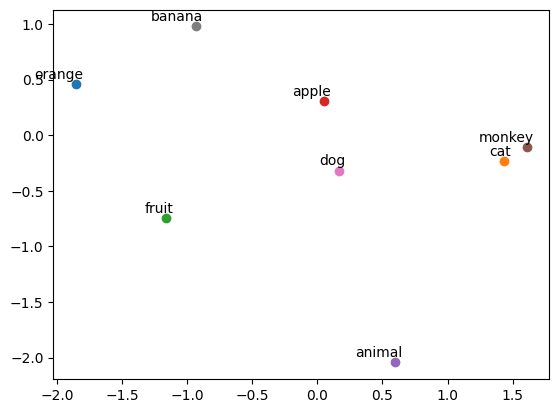

In [19]:
model = Word2Vec()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(5000):
    input_batch, target_batch = random_batch()
    input_batch = torch.Tensor(input_batch)
    target_batch = torch.LongTensor(target_batch)

    optimizer.zero_grad()
    output = model(input_batch)

    # output : [batch_size, voc_size], target_batch : [batch_size] (LongTensor, not one-hot)
    loss = criterion(output, target_batch)
    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

for i, label in enumerate(word_list):
    W, WT = model.parameters()
    x, y = W[0][i].item(), W[1][i].item()
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

## 练习

- 构造一个复杂一些的数据集，中文

- 分别用跳元和词袋模型训练word2vec，embed size尽量大一些，训练完用相似的词的embedding的相似度（余弦或者欧式）